In [1]:
import torch
import torchvision
from torchvision import transforms, utils, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from random import randint

import psycopg2,datetime,heapq

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib

import os
import shutil

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# from sklearn.metrics.pairwise import cosine_similarity


import seaborn as sns

import random
import ipyplot
from tqdm import tqdm
from livelossplot import PlotLosses

torch.manual_seed(4096)

directory = '../lab_img_content_text_gray/'

def readgroup():
    #Group List
    #os.chdir('/home/jack/4_Selenium')
    with open(directory + "top.txt",encoding="utf-8") as f:
        top = f.read().split("\n")
    with open(directory + "all.txt",encoding="utf-8") as f:
        allg = f.read().split("\n")
    #print(top,allg)

    run = {}
    for x in allg:
        #print(x)
        if x in top:
            head = x[:2]
            #print(head)
        else:
            #run.append((head+"-"+x[1]+"-00",x[3:]))
            run[head+"-"+x[1]+"-00"] = x[3:]
    # for i in run:
    #     print(i)
    #print(len(run))
    return run
labels_dict = readgroup()
# labels_dict

In [33]:
conn = psycopg2.connect(database="trademark1", user="tm_root", password="roottm_9823a", host="trueint.lu.im.ntu.edu.tw", port="5433")
cur = conn.cursor()

# 從資料庫撈出純圖片資料

In [34]:
%%time
caseno_list = []
cur.execute("SELECT trademark.caseno, trademark.doc, trademark.Trademark_Design, rcp.FileName \
            FROM trademark  INNER JOIN  rcc ON (trademark.caseno = rcc.caseno) \
             INNER JOIN rcp ON ( trademark.caseno = rcp.caseno  ) \
")
# where ( text.chinese is null and text.english is null and text.japanese is null and text.symbol is null) \
#         ") 
r = cur.fetchall()

CPU times: user 383 ms, sys: 107 ms, total: 490 ms
Wall time: 1.5 s


In [35]:
caseno_list += [i for i in r]
len(caseno_list)

851167

In [51]:
# data = pd.DataFrame(caseno_list, columns=['caseno', 'doc', 'design', 'filename'])
# data['path'] = '/service/trademark/raw_register_data/' + data.doc+ '/' + data.filename
# data.dropna(inplace=True)
# data.drop(columns=[ 'doc', 'design'], inplace=True)
# data.drop_duplicates(inplace=True)
# data.to_csv('img_index.csv', index=False)

# Load image

In [2]:
data = pd.read_csv('img_index.csv', index_col='caseno')
data

filename  \
caseno                                               
99054987   imagesdata/egimg_099054987_1_038017.jpg   
99035795   imagesdata/egimg_099035795_1_038017.jpg   
99041623   imagesdata/egimg_099041623_1_038017.jpg   
99055642   imagesdata/egimg_099055642_1_038017.jpg   
99056128   imagesdata/egimg_099056128_1_038017.jpg   
...                                            ...   
109019278  imagesdata/egimg_109019278_1_048005.jpg   
109022621  imagesdata/egimg_109022621_1_048005.jpg   
109033846  imagesdata/egimg_109033846_1_048005.jpg   
109050740  imagesdata/egimg_109050740_1_048005.jpg   
109053873  imagesdata/egimg_109053873_1_048005.jpg   

                                                        path  
caseno                                                        
99054987   /service/trademark/raw_register_data/Trademark...  
99035795   /service/trademark/raw_register_data/Trademark...  
99041623   /service/trademark/raw_register_data/Trademark...  
99055642   /service/trademark/raw_register_data/Trademark...  
99056128   /service/trademark/raw_register_data/Trademark...  
...                                                      ...  
109019278  /service/trademark/raw_register_data/Trademark...  
109022621  /service/trademark/raw_register_data/Trademark...  
109033846  /service/trademark/raw_register_data/Trademark...  
109050740  /service/trademark/raw_register_data/Trademark...  
109053873  /service/trademark/raw_register_data/Trademark...  

[658614 rows x 2 columns]

In [3]:
miss_imgs = []
print(data.shape[0])
for (index,path) in  enumerate(data.path):
    if os.path.isfile(path) is False:
        miss_imgs.append(path)

print()    
print(miss_imgs) 


658614

['/service/trademark/raw_register_data/TrademarkRegXMLB_039024/imagesdata/egimg_101026878_1_039024.jpg', '/service/trademark/raw_register_data/TrademarkRegXMLB_039020/imagesdata/egimg_101021075_1_039020.jpg', '/service/trademark/raw_register_data/TrademarkRegXMLB_040011/imagesdata/egimg_101056946_1_040011.jpg']


In [4]:
# with open('miss_imgs', 'w') as f:
#     for line in miss_imgs:
#         f.write(line)
#         f.write('\n')

In [5]:
miss_imgs = []
with open('miss_imgs', 'r') as f:
        miss_imgs = f.readlines()
        miss_imgs = [i.strip() for i in miss_imgs]
print(miss_imgs)

['/service/trademark/raw_register_data/TrademarkRegXMLB_039024/imagesdata/egimg_101026878_1_039024.jpg', '/service/trademark/raw_register_data/TrademarkRegXMLB_039020/imagesdata/egimg_101021075_1_039020.jpg', '/service/trademark/raw_register_data/TrademarkRegXMLB_040011/imagesdata/egimg_101056946_1_040011.jpg']


In [6]:
data = data[~data.path.isin(miss_imgs)]

In [7]:
miss = data.path.isin(miss_imgs)
data = data[~miss]
data.index.value_counts()

105042595    6
101026773    6
103042226    6
101068170    6
101026777    6
            ..
106074822    1
106057344    1
106064204    1
106074429    1
109053873    1
Name: caseno, Length: 656456, dtype: int64

In [8]:
device = 'cuda'
PATH = directory + "resnet152_no_fc.pt"
checkpoint = torch.load(PATH, map_location=device)

model_no_fc = models.resnet152(pretrained=True)
model_no_fc = torch.nn.Sequential(*(list(model_no_fc.children())[:-1]))
model_no_fc.load_state_dict(checkpoint['model_state_dict'])
model_no_fc = model_no_fc.to(device)

model_no_fc.eval()
model_no_fc.training

False

In [9]:
class train_set(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ])
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        image = Image.open(self.data.path.iloc[idx]).convert('L').convert('RGB')
        image = self.transform(image)
        return image

In [11]:
train_data = train_set(data)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=False,num_workers=6,pin_memory=True)


In [12]:
def image_loader(image_name):
    
    loader = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    image = Image.open(image_name).convert('L').convert('RGB')
#     image = Image.open(image_name).convert('RGB')

    image = loader(image).float()
    image = image.clone().detach()
    image = image.unsqueeze(0)
    return image


laten_vec_train = []

with torch.no_grad():
    for img in tqdm(train_loader):
        img = img.to(device)
        out = model_no_fc(img).cpu()
        out = torch.squeeze(out)
        out = out.detach().numpy()
        laten_vec_train.append(out)

laten_vec_train = np.vstack(laten_vec_train)


100%|██████████| 20582/20582 [47:10<00:00,  7.27it/s]


In [14]:
laten_vec_train.shape

(658611, 2048)

## Store latent vectors and according path

In [12]:
# %%time
# np.savetxt('./latent_vectors.csv', laten_vec_train, delimiter=',')

CPU times: user 4min 18s, sys: 4.59 s, total: 4min 23s
Wall time: 4min 34s


In [27]:
# train_data.df_merge.path.to_csv('latent_vector_path.csv',index=True)

In [23]:
# data.path.to_csv('latent_vector_path.csv',index=True)

## Read latent vectors

In [29]:
%%time
laten_vec_train = pd.read_csv('/service/trademark/latent_vectors/latent_vectors.csv', header=None)
laten_vec_train = laten_vec_train.values

CPU times: user 4min 19s, sys: 20.8 s, total: 4min 40s
Wall time: 5min 2s


In [35]:
laten_vec_train.shape

(658611, 2048)

In [37]:
latent_vector_path = pd.read_csv('latent_vector_path.csv')

In [39]:
latent_vector_path

caseno                                               path
0        99054987  /service/trademark/raw_register_data/Trademark...
1        99035795  /service/trademark/raw_register_data/Trademark...
2        99041623  /service/trademark/raw_register_data/Trademark...
3        99055642  /service/trademark/raw_register_data/Trademark...
4        99056128  /service/trademark/raw_register_data/Trademark...
...           ...                                                ...
658606  109019278  /service/trademark/raw_register_data/Trademark...
658607  109022621  /service/trademark/raw_register_data/Trademark...
658608  109033846  /service/trademark/raw_register_data/Trademark...
658609  109050740  /service/trademark/raw_register_data/Trademark...
658610  109053873  /service/trademark/raw_register_data/Trademark...

[658611 rows x 2 columns]

In [41]:
device = 'cpu'
PATH = "/home/slimon/2021_trademark_project/slimon/model/lab_img_content_text_gray/resnet152_no_fc.pt"
checkpoint = torch.load(PATH, map_location=device)

model_no_fc = models.resnet152(pretrained=True)
model_no_fc = torch.nn.Sequential(*(list(model_no_fc.children())[:-1]))
model_no_fc.load_state_dict(checkpoint['model_state_dict'])
model_no_fc = model_no_fc.to(device)

model_no_fc.eval()
model_no_fc.training

False

## Retrieval (Cosine similarity)

先把 latent vector 標準化

In [42]:
laten_vec_train = laten_vec_train/np.linalg.norm(laten_vec_train, axis=1, keepdims=True)

In [46]:
# def cosine_similarity(x, y):
#     a = np.dot(x, y)
#     b = np.linalg.norm(x) * np.linalg.norm(y)
#     return a/b

In [47]:
def image_loader(image_name):
    
    loader = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    image = Image.open(image_name).convert('L').convert('RGB')
#     image = Image.open(image_name).convert('RGB')

    image = loader(image).float()
    image = image.clone().detach()
    image = image.unsqueeze(0)
    return image



def single_img_retrieve(img_path):
    img = image_loader(img_path)
    img = img.to(device)
    out = model_no_fc(img).cpu()
    out = torch.squeeze(out)
    out = out.detach().numpy()

    
    out_norm = np.linalg.norm(out)
    
#     similarities = []
#     for v in laten_vec_train:
#         similarities.append(cosine_similarity(out, v))
    
    similarities = np.dot(laten_vec_train, out / out_norm)

    index = np.argsort(similarities)[-10:]  # Returns the indices that would sort an array. 取倒數20個也就是前20大的index
    index = np.flip(index)
    img = Image.open(img_path)
    img = img.resize((128,128),Image.ANTIALIAS)
    display(img)
    temp = []
    caseno_list = []
    for c,p in zip(latent_vector_path.caseno[index], latent_vector_path.path[index]):
        img = Image.open(p)
        img = img.resize((128,128),Image.ANTIALIAS)
        temp.append(img)
        caseno_list.append(c)

    print(caseno_list)
    ipyplot.plot_class_representations(temp, np.array(similarities)[index], img_width=100)
    


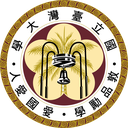

KeyError: "None of [Int64Index([383531, 649109, 184381,  41016, 467709, 282419, 280279, 273382,\n            358493, 584884, 569170, 181259, 181574,  38270, 284302,  78900,\n            634611,  58406,  58599, 222693, 372753, 576287, 267630, 267431,\n            308604, 213435, 328446, 410903, 531466, 574793, 471816, 183560,\n            101691, 574814, 533453,  81936, 287081, 328245, 185346, 473469,\n            412050, 215641, 607261,  21304, 605970, 587564, 483507, 607637,\n            380884, 235178],\n           dtype='int64')] are in the [columns]"

In [48]:
%%time
single_img_retrieve('/home/slimon/ntu.jpg')

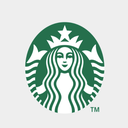


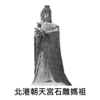
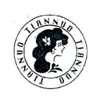
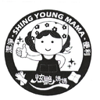
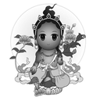
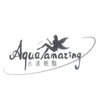
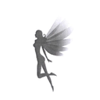
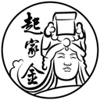
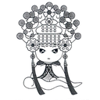
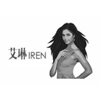
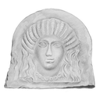
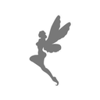
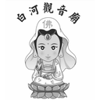
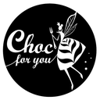
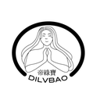
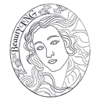
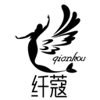
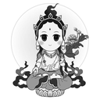
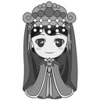
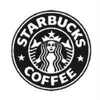
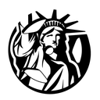
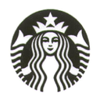
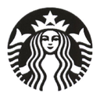
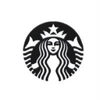
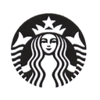
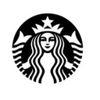


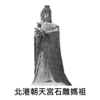
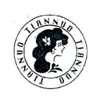
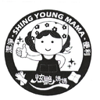
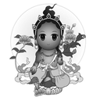
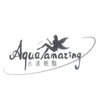
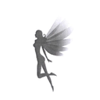
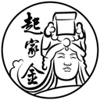
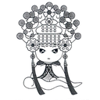
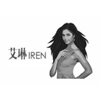
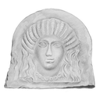
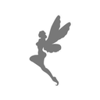
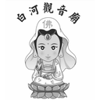
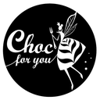
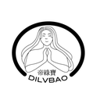
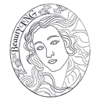
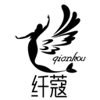
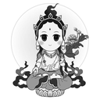
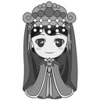
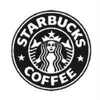
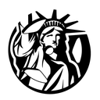
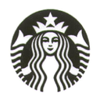
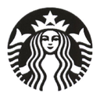
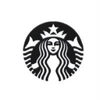
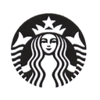
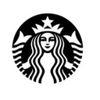

In [72]:
single_img_retrieve('/home/slimon/starbucks.jpg')

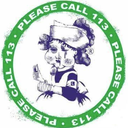


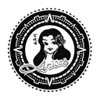
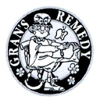
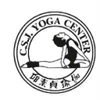
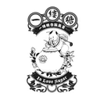
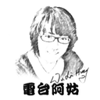
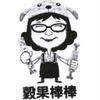
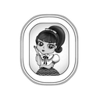
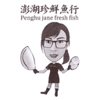
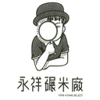
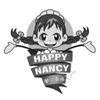
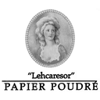
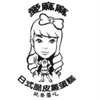
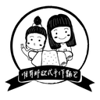
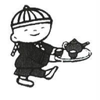
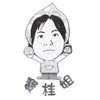
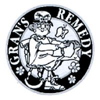
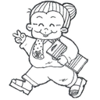
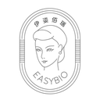
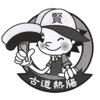
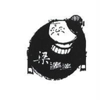
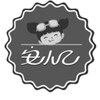
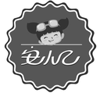
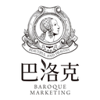
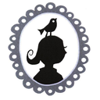
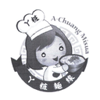
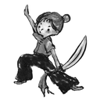
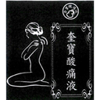
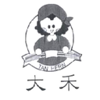
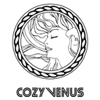
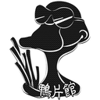
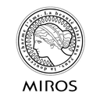
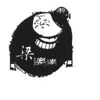
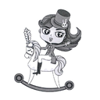
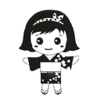
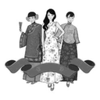
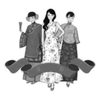
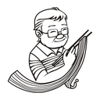
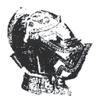
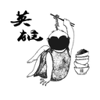
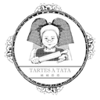
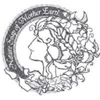


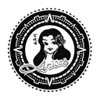
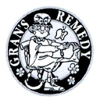
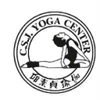
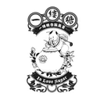
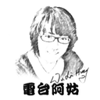
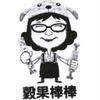
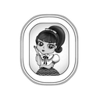
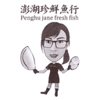
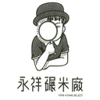
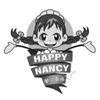
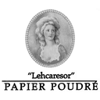
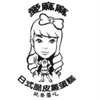
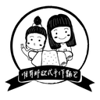
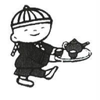
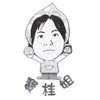
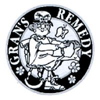
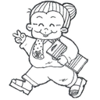
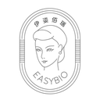
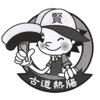
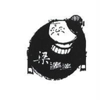
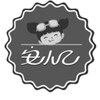
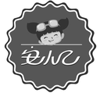
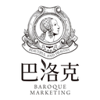
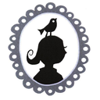
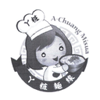
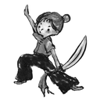
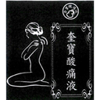
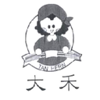
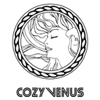
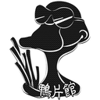
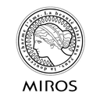
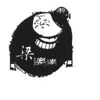
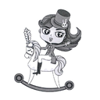
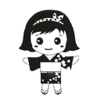
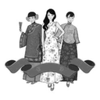
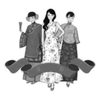
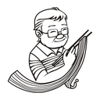
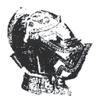
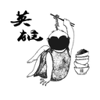
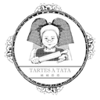
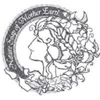

In [73]:
single_img_retrieve('/home/slimon/nurse.jpg')

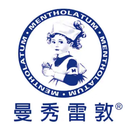


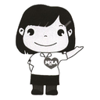
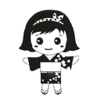
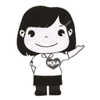
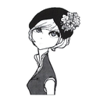
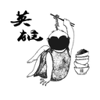
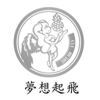
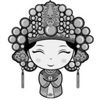
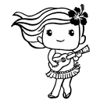
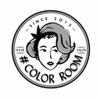
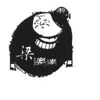
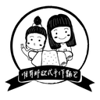
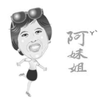
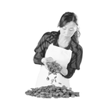
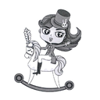
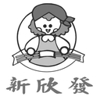
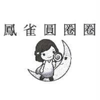
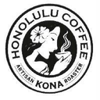
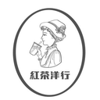
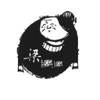
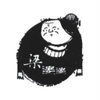
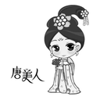
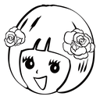
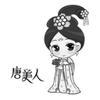
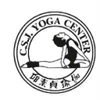
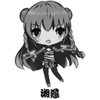
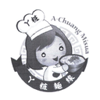
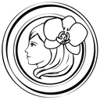
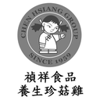
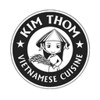
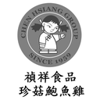
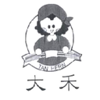
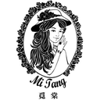
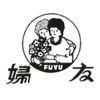
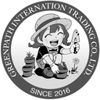
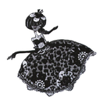
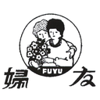
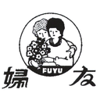


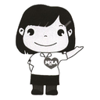
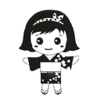
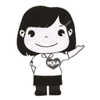
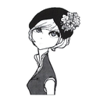
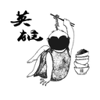
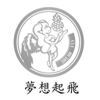
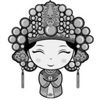
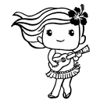
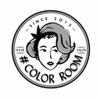
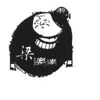
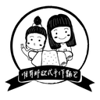
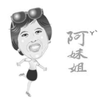
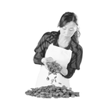
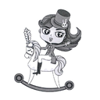
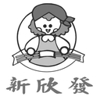
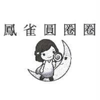
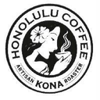
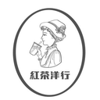
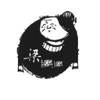
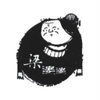
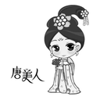
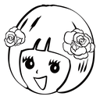
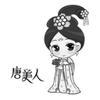
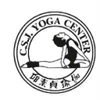
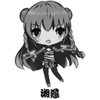
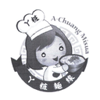
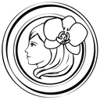
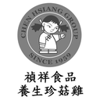
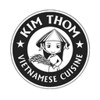
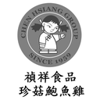
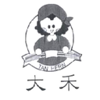
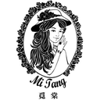
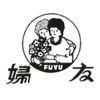
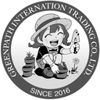
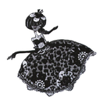
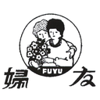
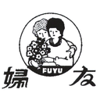

In [74]:
single_img_retrieve('/home/slimon/nurse_1.jpeg')

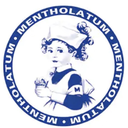


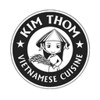
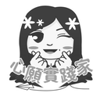
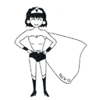
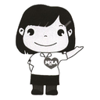
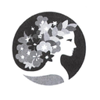
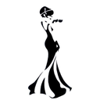
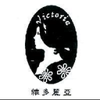
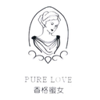
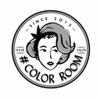
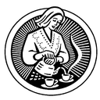
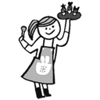
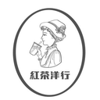
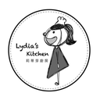
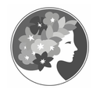
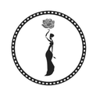
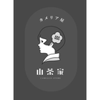
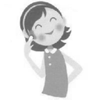
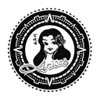
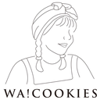
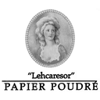
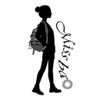
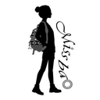
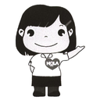
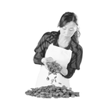
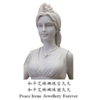
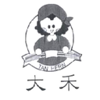
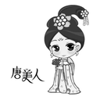
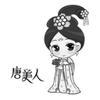
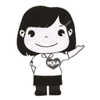
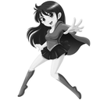
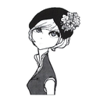
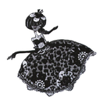
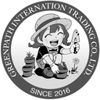
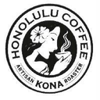
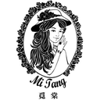
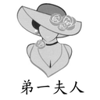


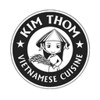
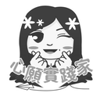
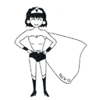
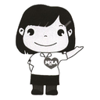
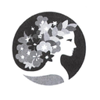
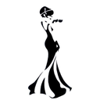
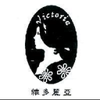
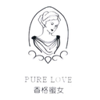
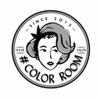
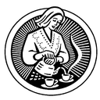
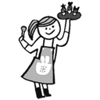
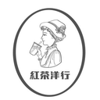
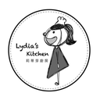
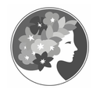
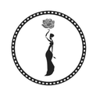
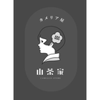
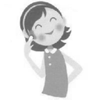
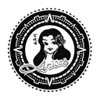
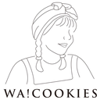
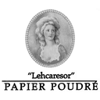
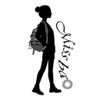
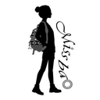
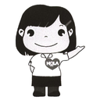
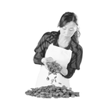
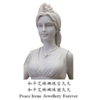
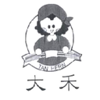
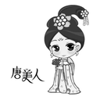
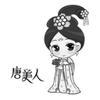
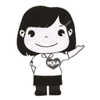
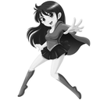
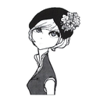
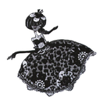
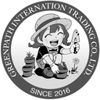
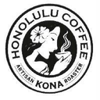
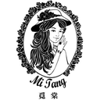
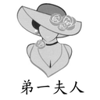

In [75]:
single_img_retrieve('/home/slimon/nurse_2.jpg')

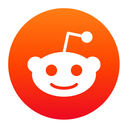


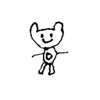
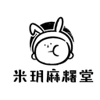
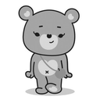
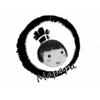
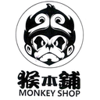
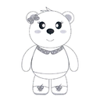
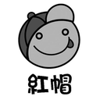
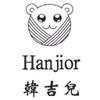
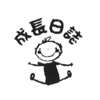
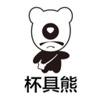
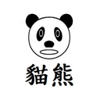
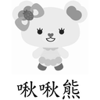
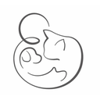
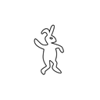
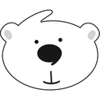
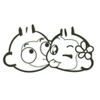
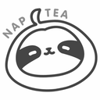
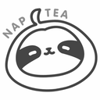
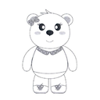
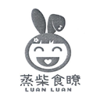
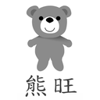
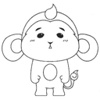
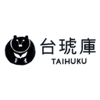
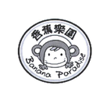
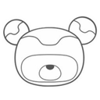
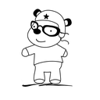
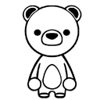
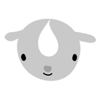
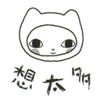
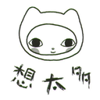
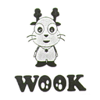
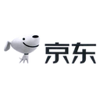
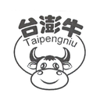
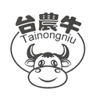
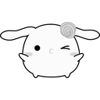
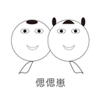
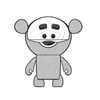
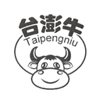


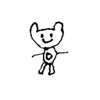
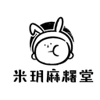
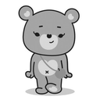
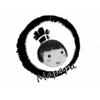
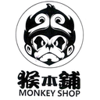
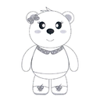
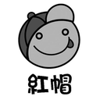
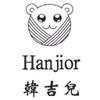
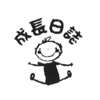
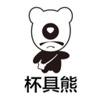
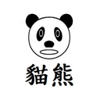
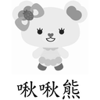
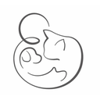
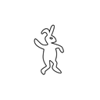
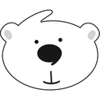
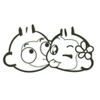
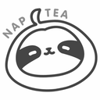
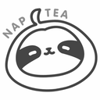
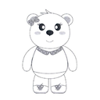
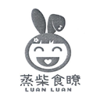
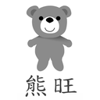
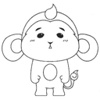
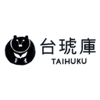
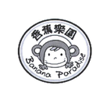
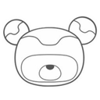
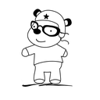
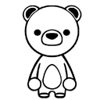
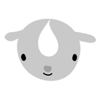
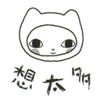
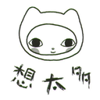
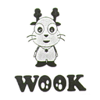
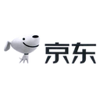
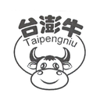
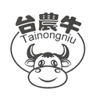
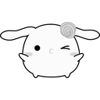
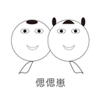
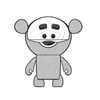
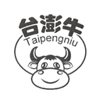

In [76]:
single_img_retrieve('/home/slimon/reddit.jpg')

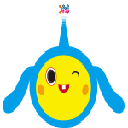


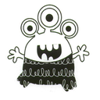
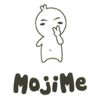
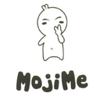
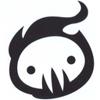
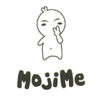
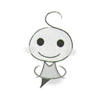
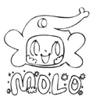
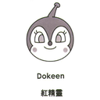
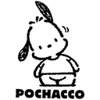
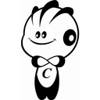
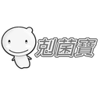
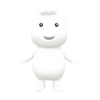
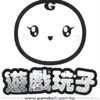
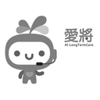
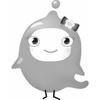
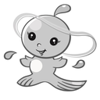
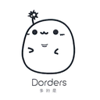
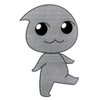
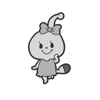
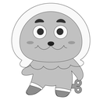
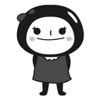
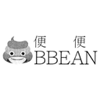
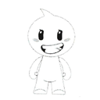
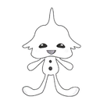
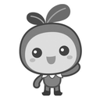
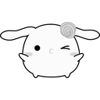
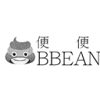
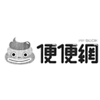
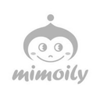
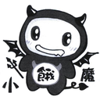
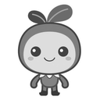


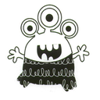
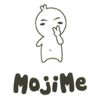
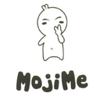
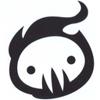
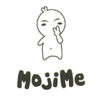
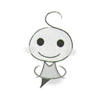
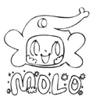
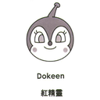
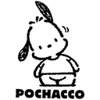
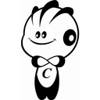
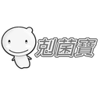
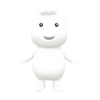
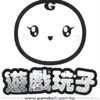
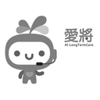
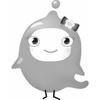
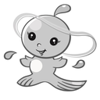
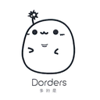
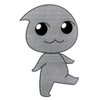
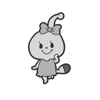
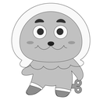
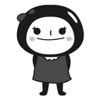
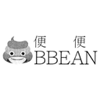
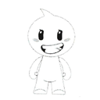
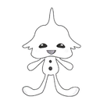
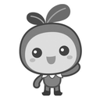
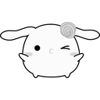
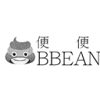
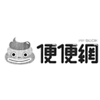
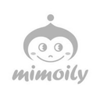
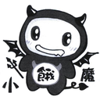
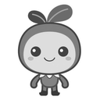

In [77]:
single_img_retrieve('/home/slimon/ximake.jpg')

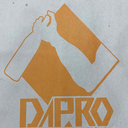


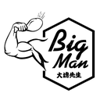
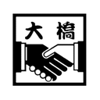
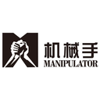
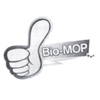
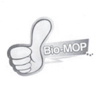
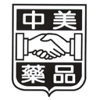
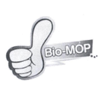
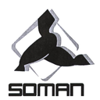
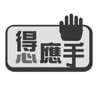
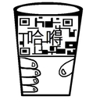
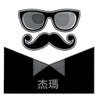
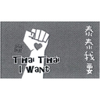
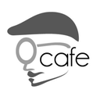
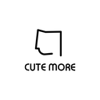
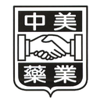
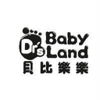
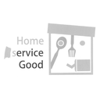
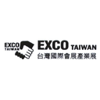
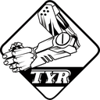
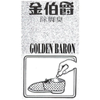
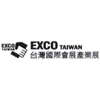
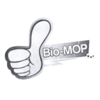
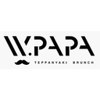
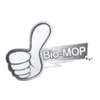
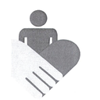
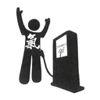
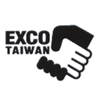
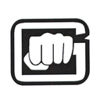
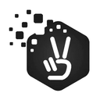
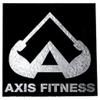
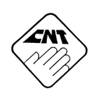
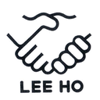
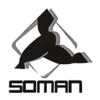
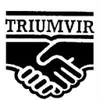
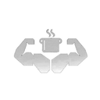
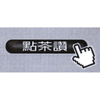
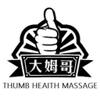
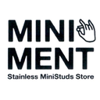
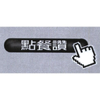
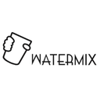
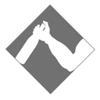
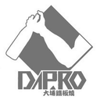


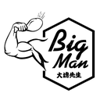
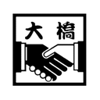
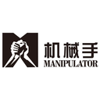
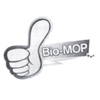
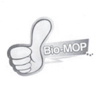
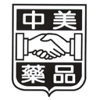
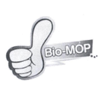
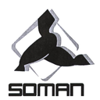
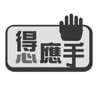
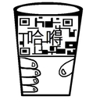
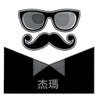
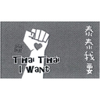
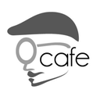
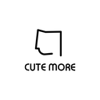
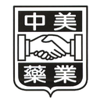
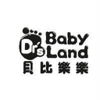
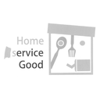
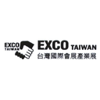
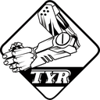
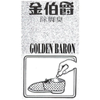
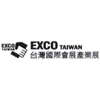
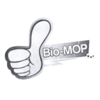
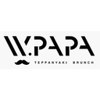
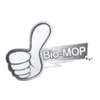
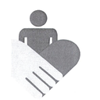
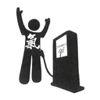
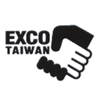
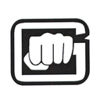
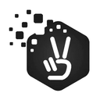
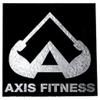
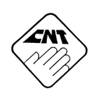
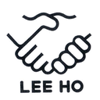
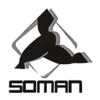
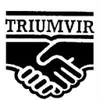
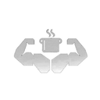
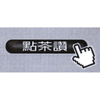
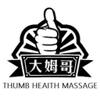
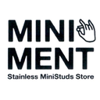
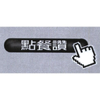
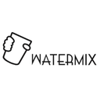
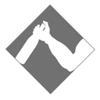
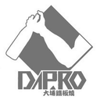

In [78]:
single_img_retrieve('/home/slimon/大埔1.jpg')

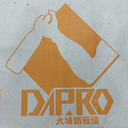


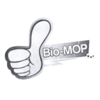
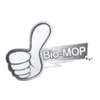
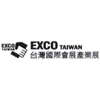
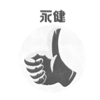
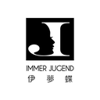
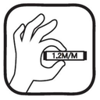
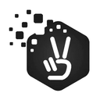
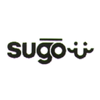
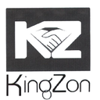
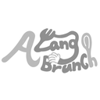
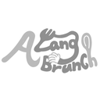
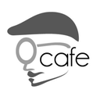
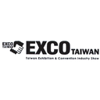
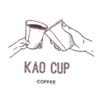
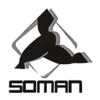
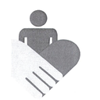
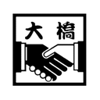
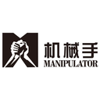
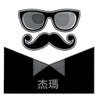
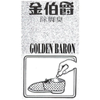
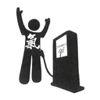
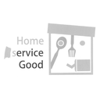
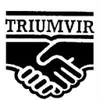
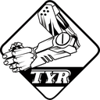
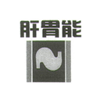
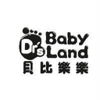
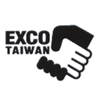
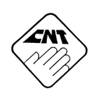
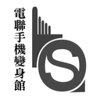
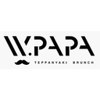
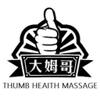
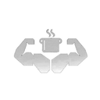
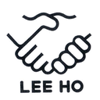
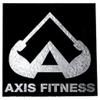
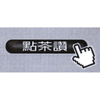
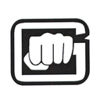
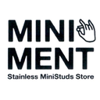
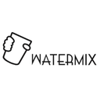
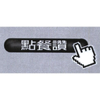
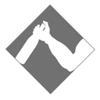
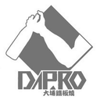


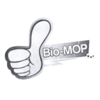
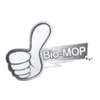
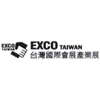
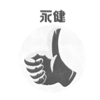
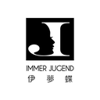
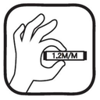
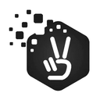
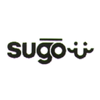
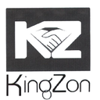
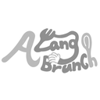
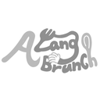
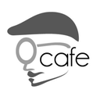
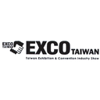
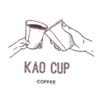
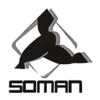
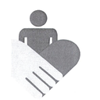
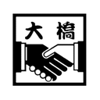
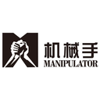
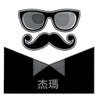
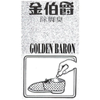
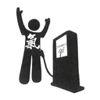
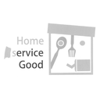
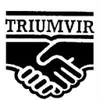
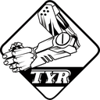
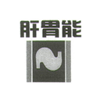
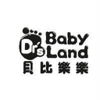
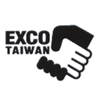
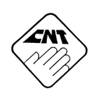
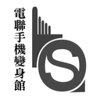
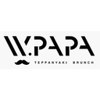
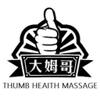
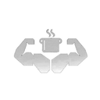
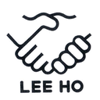
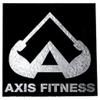
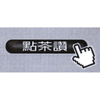
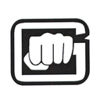
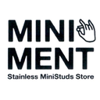
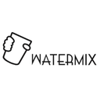
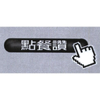
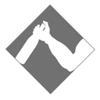
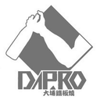

In [79]:
single_img_retrieve('/home/slimon/大埔2.jpg')

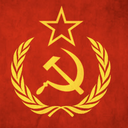


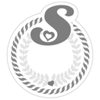
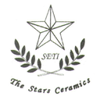
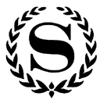
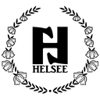
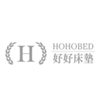
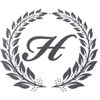
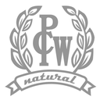
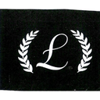
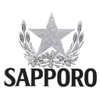
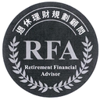
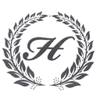
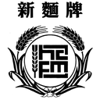
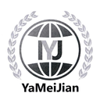
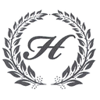
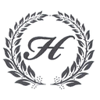
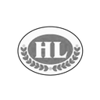
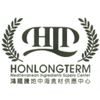
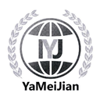
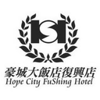
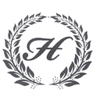
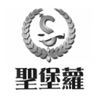
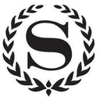
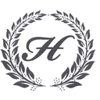
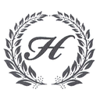
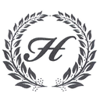
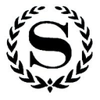
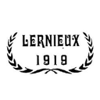
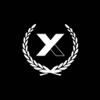
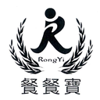
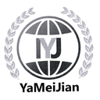
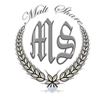
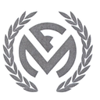
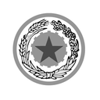
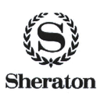
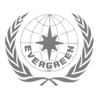
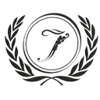
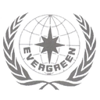
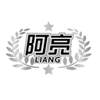
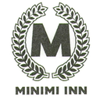
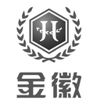
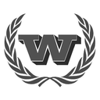
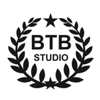
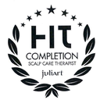


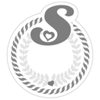
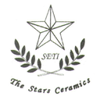
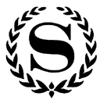
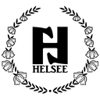
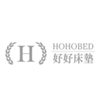
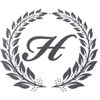
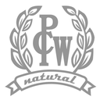
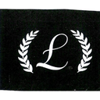
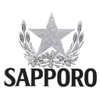
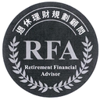
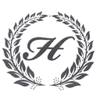
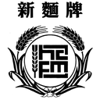
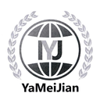
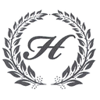
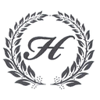
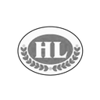
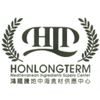
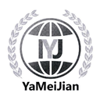
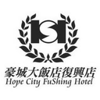
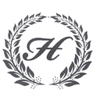
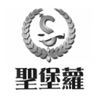
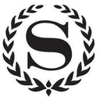
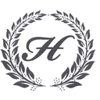
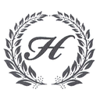
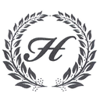
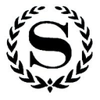
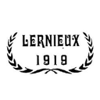
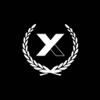
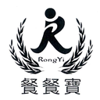
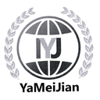
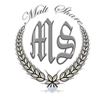
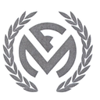
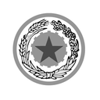
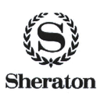
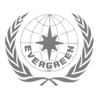
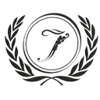
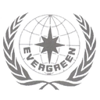
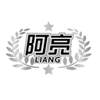
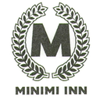
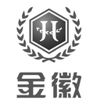
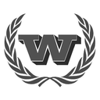
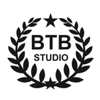
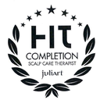

In [80]:
single_img_retrieve('/home/slimon/soviet.jpg')